In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from math import *
import time
import socket
import random
import os
#import numpy
from scipy import special
from scipy import linalg


## The quantized kicked rotor 

The Hilbert space is on $\theta \in [0, 2 \pi]$. 

With  Hamiltonian 
$$\hat H = \frac{\hat p^2}{2I} + k\cos \hat \theta \sum_{j=-\infty}^\infty \delta(t - jT) $$
we define
$$\hat U = e^{-i \hat H t/\hbar}$$ 
and let operator $\hat p = -i \hbar \partial_\theta $. 
We use a momentum basis with $$|m\rangle = \frac{1}{\sqrt{2}} \int_0^{2 \pi} d\theta \ e^{im\theta} |\theta\rangle $$
The matrix elements (after a computation) are 
$$ \langle m' | \hat U |m \rangle = U_{m'm}  =  i^{m-m'} J_{m-m'} \left( \frac{k}{\hbar}\right) e^{- \frac{ iT \hbar m^2 }{2 I}  }. $$


We define two dimensionless parameters 
$$ \alpha \equiv \frac{T\hbar}{I} \qquad K \equiv \frac{k T}{I} $$
The matrix elements become 
$$ U_{m'm}  =  i^{m-m'} J_{m-m'} \left( \frac{K}{\alpha}\right) e^{- \frac{ i \alpha  m^2 }{2}  }. $$

The $\alpha$ parameter is sometimes called $\hbar_s$ (e.g., see the review Santhanam et al. 2022, Physics Reports, 956,  1–87) and goes to zero in the classical limit.  The $K$ parameter is that of the related Standard map.


We compute the eigenvalues for a matrix that goes out to a maximum $\pm m$ value. 
This is truncating the matrix.
The matrix is supposed to be unitary but because we compute the eigenvalues with a truncated matrix,
some of the eigenvalues are not on the unit circle.
If $K/\alpha$ is larger then I find you need a larger $n$ to keep eigenvalues on the unit circle.
It is probably a good idea to check that the eigenvalues are on the unit circle everytime you compute eigenvalues
of a unitary matrix. 



In [190]:
# Fill a matrix U_m'm and return the matrix and its eigenvalues and eigenvectors 
# arguments: 
#   n is basis_size of truncated Hilbert space
#   alpha,  K_over_alpha = K/alpha, these are parameters needed to compute U_m'm
# returns:
#   U_matrix, eigenvalues and eigenvectors of U
def Qkicked(n,alpha,K_over_alpha):
    
    # allocate space for some Bessel functions 
    tab_bessel=np.zeros(2*n)  
    #compute the Bessel functions 
    for i in range(len(tab_bessel)):
        tab_bessel[i]=special.jv(i-n,K_over_alpha)  # note i-n here for indexing from -n to n-1
        #see https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.jv.html#scipy.special.jv
   
    # allocate space for the operator U
    U_matrix =np.zeros((n,n),dtype=complex)  # for storing U_m'm
    # indexing from m = -n/2 to n/2-1 in both indices 
    
    quasi_momentum = 0.1  # why used by Delande I don't know, tried it to see if it helped. I think not. 
    # fill the matrix, computing U_m'm
    for i in range(n):
        mi  = i - int(n/2) +quasi_momentum # mi goes from -n/2 to n/2-1, this is index m
        complex_factor = np.exp(-1j * 0.5*mi**2*alpha)  # this is e^(-i m^2 alpha/2)
        for j in range(n):
            # mj = j - int(n/2)  #    this is index m' but we don't need to compute it 
            # note that   m - m' = mi-mj = i-j
            i_factor = (1j)**(i-j)   # this is i^(m-m')
            ibessel = i-j+n  # index for Bessel function  is m-m'   add n because of indexing above 
            U_matrix[j,i]=complex_factor*i_factor*tab_bessel[ibessel] # this is U_{m'm}
        
    # compute the eigenvalues and eigenvectors 
    (w,vr)=linalg.eig(U_matrix)  # find eigenvalues and eigenvectors 
    # w  is an array of the complex eigenvalues, vr has eigenvectors in it 
    return w, vr, U_matrix

# plot an array of eigenvalues on the complex plane
def plot_eigenvalues(w):
    Re_part = np.real(w)
    Im_part = np.imag(w)
    fig,ax = plt.subplots(1,1,figsize=(3,3))
    ax.set_aspect('equal')
    ax.plot(Re_part,Im_part,'o',ms=1)
    #Joy= if U is unitary eigenvalues should be on unit circle!  

# arguments: w an array of complex eigenvalues, assumed roots of unity
# returns: an array of normalized differences between the phases of the eigenvalues 
twopi = np.pi*2
def compute_s(w):
    phi_arr = np.angle(w) # get the phase angles in [-pi,pi] of complex numbers
    # this ignores magnitude of w if it is not on the unit circle 
    phi_arr_sort = np.sort(phi_arr)  # put in order of increasing phase
    phi_shift = np.roll(np.copy(phi_arr_sort),1)
    dphi = (phi_arr_sort - phi_shift + np.pi)%twopi - np.pi  # takes care of 2pi shift
    mu_dphi = np.mean(dphi)  # find mean value of dphi 
    sarr = dphi/mu_dphi  # this is s /<s>
    return sarr  # returns normalized phase differences 

# create a probability vector for the i-th eigenvector 
def get_probs(vr,i):
    v = vr[i]
    probi = np.real(np.conjugate(v)*v) # probability vector 
    return probi



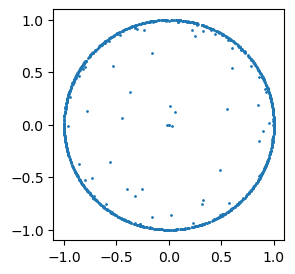

In [3]:
# sets size of matrix.  We truncate at high |m|
n=1024  # basis elements go from m=-n/2 to +n/2-1

# choosing dimensionless parameters for the model 
K_over_alpha=12 
alpha = 1.0  #

w_a,vr_a,U_matrix_a = Qkicked(n,alpha,K_over_alpha)  # compute the matrix and eigenvalues!
plot_eigenvalues(w_a)
# Note that they are not all on the unit circle,
# by truncating the system,  U is no longer unitary

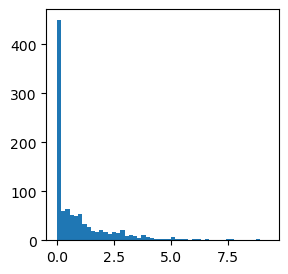

In [88]:
sarr_a = compute_s(w_a)  # compute array of phase differences  
fig,ax = plt.subplots(1,1,figsize=(3,3))
junk = ax.hist(sarr,bins=50)


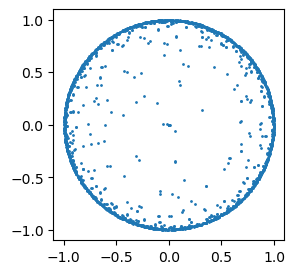

In [87]:
# redo last calcuation but with larger N
n=2048  # basis elements go from m=-n/2 to +n/2-1
w_b,vr_b,U_matrix_b = Qkicked(n,alpha,K_over_alpha)  # compute the matrix and eigenvalues!
plot_eigenvalues(w_b)
# still looks lousy

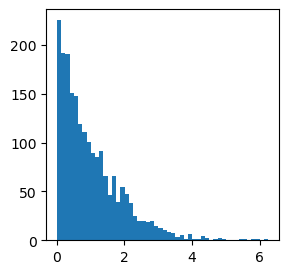

In [89]:
sarr_b = compute_s(w_b) # compute array of phase differences  
ig,ax = plt.subplots(1,1,figsize=(3,3))
junk = ax.hist(sarr_b,bins=50)

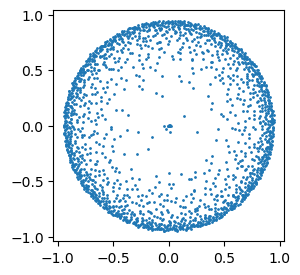

In [98]:
n=2048  # basis elements go from m=-n/2 to +n/2-1
# now do a chaotic version 
K_over_alpha = 500
alpha = 1
w_d,vr_d,U_matrix_d = Qkicked(n,alpha,K_over_alpha)  # compute the matrix and eigenvalues!
plot_eigenvalues(w_d)
sarr_d = compute_s(w_d) # compute array of phase differences  
# now it looks really bad!

## Second approach on the quantized kicked rotator, using a discrete Hilbert space to start with.

We start with an N dimensional Hilbert space. 

$\hat \theta = \sum_j \frac{2 \pi j}{N}|j \rangle \langle j| $. 

Here $\hat p$ is $\sum_m \hbar m|m\rangle_F \langle m|_F$ in the Fourier transformed basis.

The Hamiltonian is the same as above. 
$$\hat H = \frac{\hat p^2}{2I} + k\cos \hat \theta \sum_{j=-\infty}^\infty \delta(t - jT) $$

The propagator 
\begin{align}
\hat U &= Q_{FT}^\dagger \Lambda_A Q_{FT}  \Lambda_B   
  \label{eqn:Uresult2}
\end{align}
with diagonal matrices 
\begin{align}
\Lambda_A &= \sum_j e^{-\frac{ik}{\hbar} \cos (2 \pi j/N) }  |j\rangle \langle j| = 
\sum_j e^{-i \frac{K}{\alpha} \cos (2 \pi j/N) } \nonumber \\
\Lambda_B & = \sum_m e^{- \frac{ iT}{2\hbar I}  \hbar^2 m^2 } |m\rangle_F \langle m|_F
= \sum_m e^{- i\alpha m^2/2} |m\rangle_F \langle m|_F
.
\end{align}

Note $K/\alpha = k/\hbar$. 

With this approach $\hat U$ must be unitary. 


However, the commutator between $\hat \theta$ and $\hat p$ suffers.  


The Wigner function I am trying is this 

$$W_{\hat \rho} (m,n) = \frac{1}{2N} \sum_x \langle n-x| \hat \rho | n+x \rangle \omega^{2xk} $$

In [210]:
# Using a finite dimensional Hilbert space approach

# fill matrices with Discrete Fourier transform, returns 2 nxn matrices
def QFT(n):
    omega = np.exp(2*np.pi*1j/n)
    Q        = np.zeros((n,n),dtype=complex)  # QFT
    Q_dagger = np.zeros((n,n),dtype=complex) 
    for j in range(n):
        for k in range(n):
            Q[j,k] = np.power(omega,j*k)  # not 100% sure about sign here! 
            Q_dagger[j,k] = np.power(omega,-j*k)
    Q /= np.sqrt(n)  #normalize
    Q_dagger /= np.sqrt(n)
    return Q,Q_dagger 

# Fill a matrix U_m'm and return the matrix and its eigenvalues and eigenvectors 
# for the finite dim hilbert space
# arguments: 
#   n is basis_size of truncated Hilbert space
#   alpha,  K_over_alpha = K/alpha, these are parameters needed to compute U_m'm
# returns:
#   U_matrix, eigenvalues and eigenvectors of U
def Qkicked_finite(n,alpha,K_over_alpha):

    Lambda_A =np.zeros((n,n),dtype=complex)  # for storing diagonal matrix for kicked part
    Lambda_B =np.zeros((n,n),dtype=complex)  # for storing diagonal matrix for potential part
    Q_FT,Q_FT_dagger =  QFT(n) # get QFT matrices
    #Q_FT        = np.zeros((n,n),dtype=complex)  # QFT
    #Q_FT_dagger = np.zeros((n,n),dtype=complex) 
    #omega = np.exp(2*np.pi*1j/n)
    #Fill up 3 nxn complex unitary matrices 
    for j in range(n):
        Lambda_A[j,j] = np.exp(-1.0j * K_over_alpha*np.cos(2*np.pi*j/n))
        Lambda_B[j,j] = np.exp(-1.0j * alpha/2 * j*j)
        
        #for k in range(n):
            #Q_FT[j,k] = np.power(omega,j*k)  # not 100% sure about sign here! indexing issues!
            #Q_FT_dagger[j,k] = np.power(omega,-j*k)
            
    z = np.matmul(Q_FT,Lambda_B)
    zp = np.matmul(Lambda_A,z)
    U_matrix = np.matmul(Q_FT_dagger,zp)  #
    
    (w,vr)=linalg.eig(U_matrix)  # find eigenvalues and eigenvectors 
    # w  is an array of the complex eigenvalues, vr has eigenvectors in it 
    return w, vr, U_matrix

# create a point operator 
def A_pt_operator(N,j,k):
    omega = np.exp(2*np.pi*1j/N)
    fac = np.power(omega*x*k)
    Aarr = np.zeros((n,n),dtype=complex)
    for x in range(N):
        Aarr[j+x,j-x] = np.power(omega,2*x*k)/N
    return Aarr
 
# compute the Wigner function 
def Wigner(N,psi):
    Warr = np.zeros((n,n),dtype=complex)
    omega = np.exp(2*np.pi*1j/N)
    for j in range(N):
        for k in range(N):
            for x in range(N):
                Warr[j,k] += np.conjugate(psi[(j-x)%N])*psi[(j+x)%N]*np.power(omega,2*x*k)
    return Warr/(2*N)
                  
    

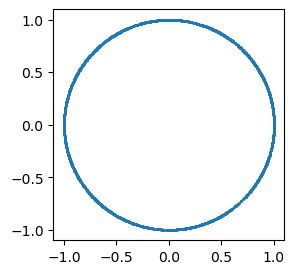

In [89]:
# sets size of matrix.  
n=2048  # 

# choosing dimensionless parameters for the model 
K_over_alpha=5 
alpha = 1.0  #

w_A,vr_A,U_matrix_A = Qkicked_finite(n,alpha,K_over_alpha)  # compute the matrix and eigenvalues!
plot_eigenvalues(w_A)
# we are assured a unitary matrix with this approach! eigenvalues are on unit circle, as expected 

Text(0.5, 0, '$s/\\langle s \\rangle$')

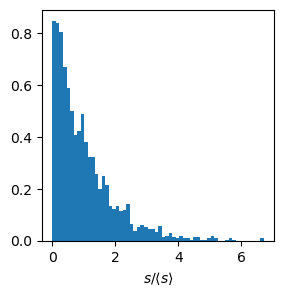

In [90]:
sarr_A = compute_s(w_A) # compute array of phase differences  
ig,ax = plt.subplots(1,1,figsize=(3,3))
junk = ax.hist(sarr_A,bins=60,density=True)
ax.set_xlabel(r'$s/\langle s \rangle$')
# Poisson distribution expected, looks ok

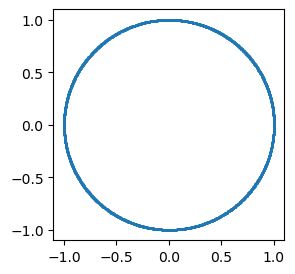

In [91]:
# sets size of matrix.  
n=2048  # 

# choosing dimensionless parameters for the model
# a more chaotic version
K_over_alpha=50 
alpha = 5.0  #

w_B,vr_B,U_matrix_B = Qkicked_finite(n,alpha,K_over_alpha)  # compute the matrix and eigenvalues!
plot_eigenvalues(w_B)
sarr_B = compute_s(w_B) # compute array of phase differences  

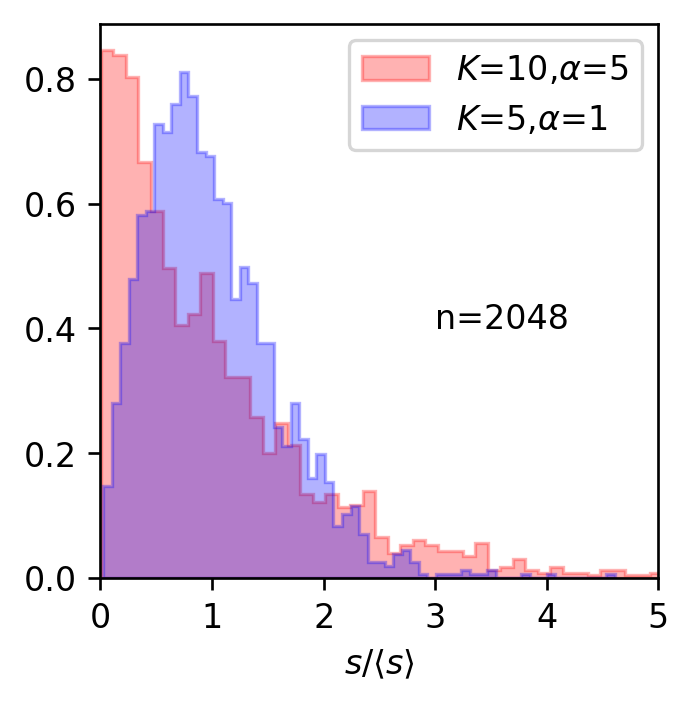

In [94]:
# make a figure comparing the chaotic and non-chaotic versions 
ig,ax = plt.subplots(1,1,figsize=(3,3),dpi=240)
ax.set_xlim([0,5])
junk2 = ax.hist(sarr_A,bins=60,density=True,alpha=0.3,color='red',ec='red',histtype='stepfilled'\
                ,label=r'$K$=10,$\alpha$=5')
junk = ax.hist(sarr_B,bins=60,density=True,alpha=0.3,color='blue',ec='blue',histtype='stepfilled'\
              ,label=r'$K$=5,$\alpha$=1')
ax.set_xlabel(r'$s/\langle s \rangle$')
ax.text(3.0,0.4,'n=2048')
ax.legend()
# now we get a Wigner distribution for the chaotic one,  yay!

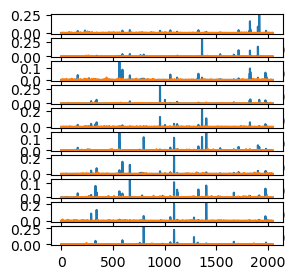

In [99]:
# lets look at the eigenvectors !
fig,axarr = plt.subplots(10,1,figsize=(3,3))
for i in range(0,10):
    p = get_probs(vr_A,i+200)
    axarr[i].plot(p)
    p = get_probs(vr_B,i+200)
    axarr[i].plot(p)
    # the look different!

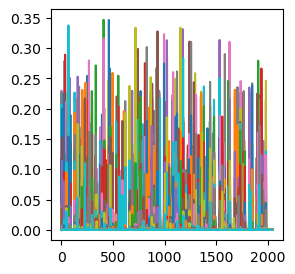

In [98]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
for i in range(0,200):
    p = get_probs(vr_A,i)
    ax.plot(p)

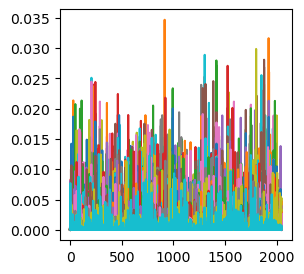

In [101]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
for i in range(0,200):
    p = get_probs(vr_B,i)
    ax.plot(p)

We find that the eigenvalues look quite different. In the chaotic setting they seem to be more 
diffusely distributed.

Text(0.5, 0, '$s/\\langle s \\rangle$')

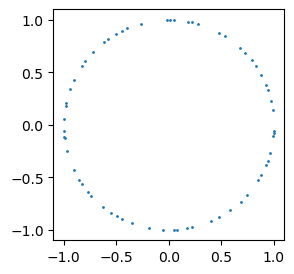

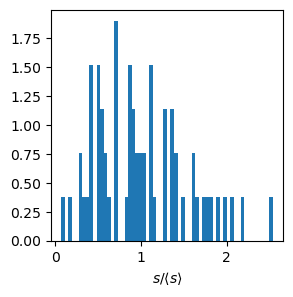

In [193]:
# now let's try making a Wigner function
# we probably need a smaller space otherwise we are going to choke

# sets size of matrix.  
n=64  # 

# choosing dimensionless parameters for the model
# a more chaotic version
K_over_alpha=50 
alpha = 5.0  #

w_C,vr_C,U_matrix_C = Qkicked_finite(n,alpha,K_over_alpha)  # compute the matrix and eigenvalues!
plot_eigenvalues(w_C)
sarr_C = compute_s(w_C) # compute array of phase differences  
ig,ax = plt.subplots(1,1,figsize=(3,3))
junk = ax.hist(sarr_C,bins=60,density=True)
ax.set_xlabel(r'$s/\langle s \rangle$')
# Wigner distribution expected, looks ok

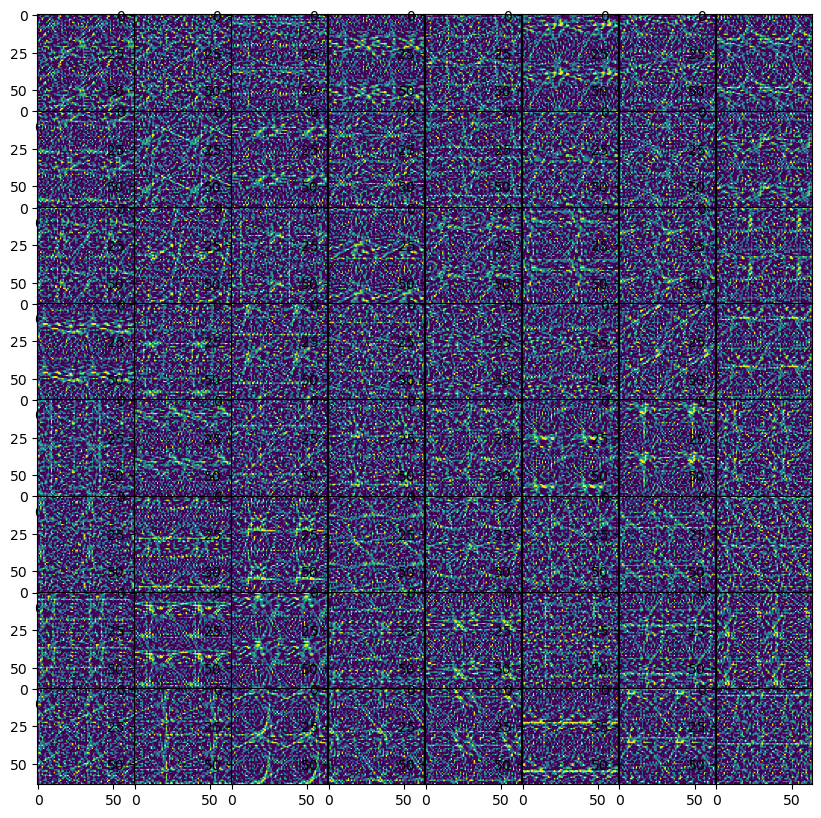

In [214]:
# this takes a while!
Ns = int(np.sqrt(n))
fig,axarr = plt.subplots(Ns,Ns,figsize=(10,10))
plt.subplots_adjust(hspace=0,wspace=0)
for j in range(Ns):
    for k in range(Ns):
        s = j*Ns + k
        W=Wigner(n,vr_C[s])
        axarr[j,k].imshow(np.real(W),vmin=0,vmax=0.002)
        #print(np.sum(Harr))

In [ ]:
#These are certainty pretty, but I am not sure if I recognize anything like periodic orbits in them.

Text(0.5, 0, '$s/\\langle s \\rangle$')

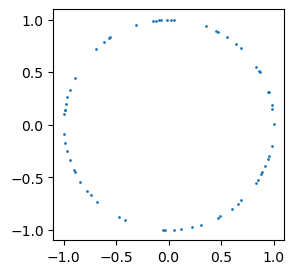

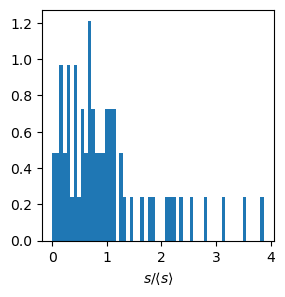

In [216]:
# now let's try making another Wigner function
# sets size of matrix.  
n=64  # 

# choosing dimensionless parameters for the model
# a less chaotic version
K_over_alpha=2 
alpha = 1.0  #

w_D,vr_D,U_matrix_D = Qkicked_finite(n,alpha,K_over_alpha)  # compute the matrix and eigenvalues!
plot_eigenvalues(w_D)
sarr_C = compute_s(w_D) # compute array of phase differences  
ig,ax = plt.subplots(1,1,figsize=(3,3))
junk = ax.hist(sarr_C,bins=60,density=True)
ax.set_xlabel(r'$s/\langle s \rangle$')
# Poisson distribution expected, looks ok

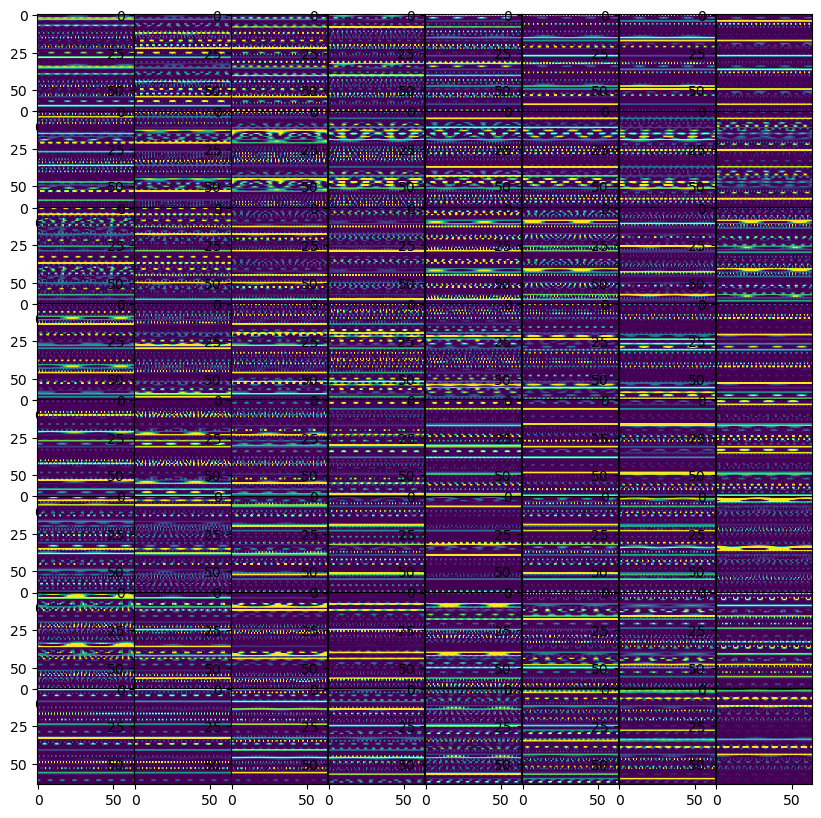

In [217]:
# this takes a while!
Ns = int(np.sqrt(n))
fig,axarr = plt.subplots(Ns,Ns,figsize=(10,10))
plt.subplots_adjust(hspace=0,wspace=0)
for j in range(Ns):
    for k in range(Ns):
        s = j*Ns + k
        W=Wigner(n,vr_D[s])
        axarr[j,k].imshow(np.real(W),vmin=0,vmax=0.002)
        #print(np.sum(Harr))

!--------------------------------------------------------------------------------!


### Coherent states for discrete periodic systems
We use a 
 nice  eigenvector of the discrete fourier transform 
$$ |\tilde \eta \rangle = \left( \frac{2}{N}  \right)^{\!\! 1/4} \sum_{m-0}^{N-1} \sum_{k \in ZN} e^{-\frac{\pi (m + Nk)^2}{N}}|m\rangle $$

We define a displacement operator
$$ D(k,l) = \omega^{-\frac{kl}{2} } \hat Z^k \hat X^l $$
where
$$\hat X = \sum_{n=0}^{N-1} |n+1\rangle \langle n|$$
$$ \hat Z = \sum_{n=0}^{N-1} \omega^n |n\rangle \langle n|$$
A coherent state can be constructed 
$$|n_0,k_0\rangle = D(k_0,n_0) |\tilde \eta \rangle$$



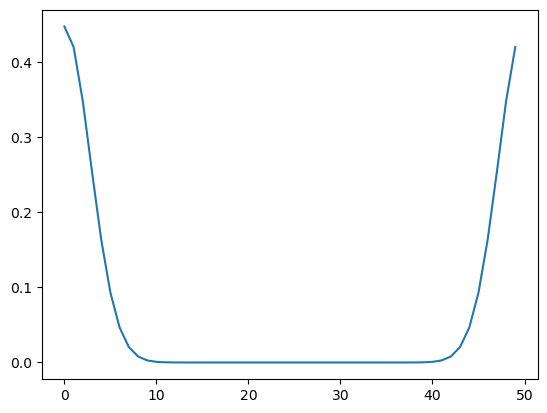

In [165]:

#Create this eigenvector of the DFT, see
#https://en.wikipedia.org/wiki/Discrete_Fourier_transform
# create |~ eta> 
def tilde_eta(N):
    evec = np.zeros(N)
    Nh = int(N/2)
    for m in range(N):
        msum = 0.0
        for k in range(-Nh,Nh+1):
            fac = (m + N*k)**2*np.pi/N  # not modulo N
            msum += np.exp(-fac)
        evec[m] = msum
    mag = np.sqrt(np.sum(evec*evec))
    #mag_c = np.power(N/2, 1./4.)
    #print(mag,mag_c) checking normalization!
    return evec/mag  # normalize

N=50
e1 = tilde_eta(N)
#print(e1)
plt.plot(e1) # plot it!

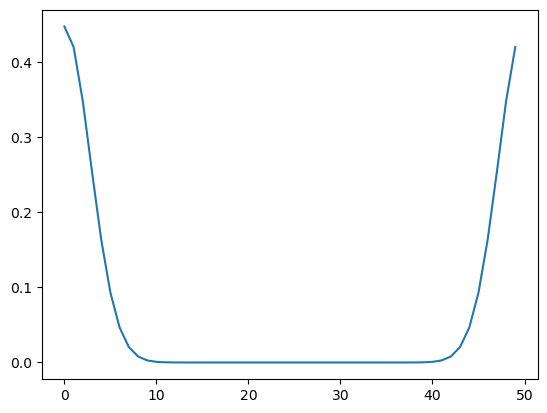

In [166]:
#N=50
#Lets check to see if it really is an eigenvector of QFT
Q,Q_dagger =  QFT(N) # get QFT matrices
ev1 = np.dot(Q,e1)  # take FT
#print(ev)
plt.plot(np.real(ev1))
# yup, it looks the same in Fourier space!

In [184]:
# create hat X operator in conventional \ket{n} basis 
def mk_hat_X(n):
    hat_X =np.zeros((n,n),dtype=complex) 
    for j in range(n):
        hat_X[(j+1)%n,j] = 1.0
    return hat_X

# create hat Z operator in conventional \ket{n} basis
def mk_hat_Z(n):
    hat_Z =np.zeros((n,n),dtype=complex) 
    omega = np.exp(2*np.pi*1j/n)
    for j in range(n):
        hat_Z[j,j] = np.power(omega,j)
    return hat_Z

# tests
#hat_X = mk_hat_X(N)
#hat_Z = mk_hat_Z(N)
#print(np.dot(e1,np.dot(hat_X,e1)))  #expval hat X
#print(np.dot(e1,np.dot(hat_Z,e1)))  #expval hat Z

# check hat X
#vec0 = np.zeros(N)
#vec0[0] = 1
#print(np.dot(hat_X,vec0)) #indexing as expected!

# create hat X^a operator in conventional \ket{n} basis
def mk_hat_X_pow(n,a):
    hat_X_a =np.zeros((n,n),dtype=complex) 
    for j in range(n):
        hat_X_a[(j+a)%n,j] = 1.0
    return hat_X_a

# create hat Z^b operator in conventional \ket{n} basis
def mk_hat_Z_pow(n,b):
    hat_Z_b =np.zeros((n,n),dtype=complex) 
    omega = np.exp(2*np.pi*1j/n)
    for j in range(n):
        hat_Z_b[j,j] = np.power(omega,j*b) # diagonal
    return hat_Z_b
        

# create |n_0,k_0> coherent state using |~eta> and hat X,hat Z operators
def mk_coherent_state(n0,k0,N):
    order = 1 # shift from 1 to -1 if you want to reverse order of X, Z ops
    teta = tilde_eta(N)  # create base state (nice state that is invariant under DFT) and is normalized
    hat_X_n0 = mk_hat_X_pow(N,n0)
    hat_Z_k0 = mk_hat_Z_pow(N,k0)
    omega_N = np.exp(2*np.pi*1j/N)
    omfac = np.power(omega_N,-n0*k0/2)
    if (order==1):
        hatZX = omfac*np.matmul(hat_Z_k0,hat_X_n0)
    else:
        hatZX = omfac*np.matmul(hat_X_n0,hat_Z_k0)  # reverse order 
    coherent_state = np.dot(hatZX,teta) # operate on |~eta> with omega^{-k_0n_0/2} \hat Z^{k_0} \hat X^{n_0} 
    return coherent_state
    

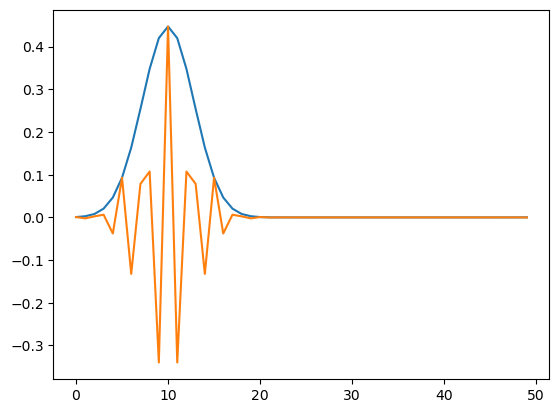

In [185]:
# plot some coherent states to see what they look like. They look great!
y = mk_coherent_state(10,0,50)
plt.plot(np.real(y))
y = mk_coherent_state(10,20,50)
plt.plot(np.real(y)) # looks ok I think

#### Baker map propagator

$$ \hat B_{BQ} = \hat Q_N^\dagger \begin{pmatrix} \hat Q_{N/2} & 0 \\ 0 & Q_{N/2} \end{pmatrix} $$
The discrete Fourier transform is 
$$\hat Q_N  = \frac{1}{\sqrt{N}} \sum_{j,k=0}^{N-1}\omega_N^{jk} |j \rangle \langle k| $$
where $\omega_N = e^{2 \pi i /N}$

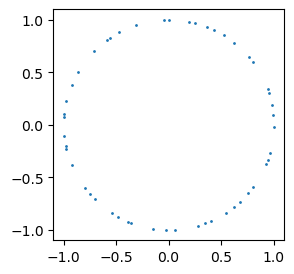

In [186]:
# compute the Baker map propagator, N should be even
# returns matrix operator for Baker map along with its eigenvalues and eigenvectors 
def fill_BQ(N):
    msign = 1  # change from 1 to -1 if you want to flip signs for exponents
    omega_N = np.exp(2*np.pi*1j/N)
    Nh = int(N/2)
    omega_Nh = np.exp(2*np.pi*1j/Nh)
    B =np.zeros((N,N),dtype=complex) 
    for j in range(Nh):
        for k in range(Nh):
            om = np.power(omega_Nh,j*k*msign)/np.sqrt(Nh)
            B[j,k] = om  # on corners 
            B[j+Nh,k+Nh] = om
            
    Q_inv = np.zeros((N,N),dtype=complex)
    for j in range(N):
        for k in range(N):
            Q_inv[j,k] = np.power(omega_N,-j*k*msign)/np.sqrt(N)
           
    hat_BQ = np.matmul(Q_inv,B)
    (w,vr)=linalg.eig(hat_BQ)  # compute eigenvalues and eigenvectors (why not!)
    return w,vr,hat_BQ
            

# tests!
N=50
w_BQa,vr_BQa,hat_BQa = fill_BQ(N) # Create the propagator for the Quantum baker map
plot_eigenvalues(w_BQa)  #is unitary, as expected!

### Husimi function 

$$H_{|\psi\rangle}(n_0,k_0) = N^{-1}|\langle \psi | n_0,k_0 \rangle |^2$$
where $| n_0,k_0 \rangle$ are coherent states. 

In [171]:
# fill a 3D array with coherent states 
# this takes a while!!!!
def fill_cohs(N):
    coh_arr = np.zeros((N,N,N),dtype=complex)
    for n0 in range(N):
        for k0 in range(N):
            coh = mk_coherent_state(n0,k0,N) # make coherent state |n0,k0>
            coh_arr[n0,k0,:] = coh # store it in 3d array
    return coh_arr

# I would like to make a Husimi distribution function 
# arguments: 
#   N dim of Hilbert space
#   wavefunction that we want Husimi function with  
#   a previously filled 3d array containing the coherent states 
# returns array of H values for different n_0 and k_0s 
def mkHusimi(N,psi,coh_arr):
    Harr = np.zeros((N,N)) 
    for n0 in range(N):
        for k0 in range(N):
            coh = np.squeeze(coh_arr[n0,k0,:])
            dprod = np.dot(psi,coh)  # should be a complex number <psi|n_0,k_0>
            Harr[n0,k0] = np.real(np.conjugate(dprod)*dprod)/N
    return Harr

# tests 
#N=50
#coh_arr = fill_cohs(50)  # this takes a while!
# probably should check the Husimi function for a coherent state
#teta = mk_coherent_state(0,0,N)  # this is |~eta>
#Harr = mkHusimi(N,teta,coh_arr)
# plt.imshow(Harr)  # looks okay

In [187]:
# 
N=64
w_BQa,vr_BQa,hat_BQa = fill_BQ(N) # Create the propagator for the Quantum baker map
coh_arr = fill_cohs(N)  # create coherent states this takes a while!


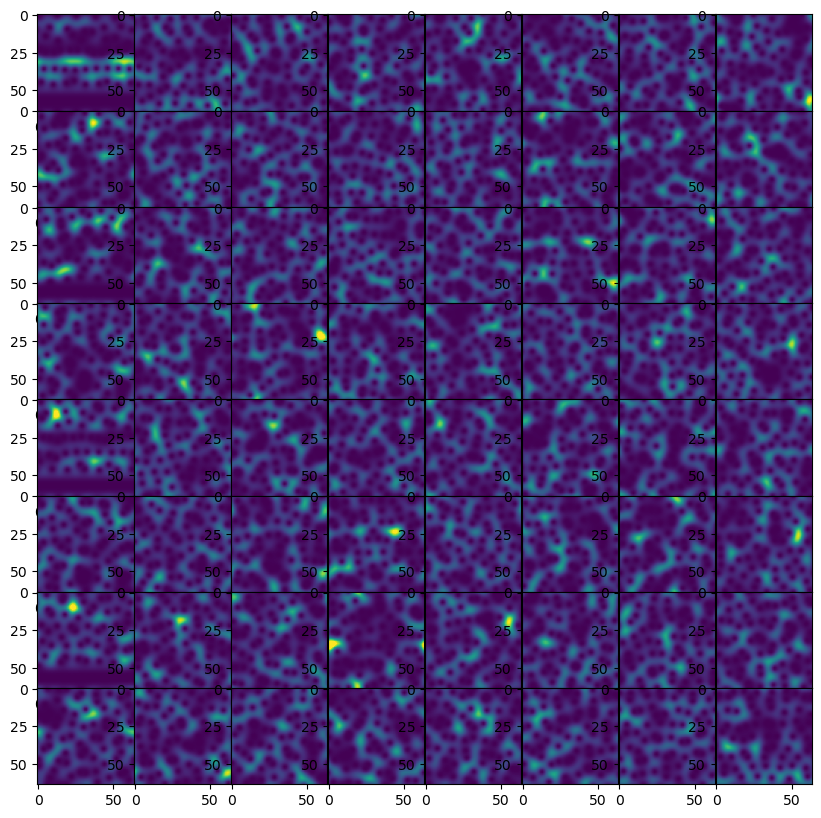

In [188]:
# plot Husimi functions for all eigenstates 
Ns = int(np.sqrt(N))
fig,axarr = plt.subplots(Ns,Ns,figsize=(10,10))
plt.subplots_adjust(hspace=0,wspace=0)
for j in range(Ns):
    for k in range(Ns):
        s = j*Ns + k
        Harr = mkHusimi(N,vr_BQa[s],coh_arr)
        axarr[j,k].imshow(Harr,vmin=0,vmax=0.002)
        #print(np.sum(Harr))

In [ ]:
# I am underwhelmed, looks like a mess, I don't recoqnize any periodic orbits either